In [1]:
#@title Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [ ]:
mkdir Revisiting_Reverse_Dissilation_Training

In [2]:
cd Revisiting_Reverse_Dissilation_Training

/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training


## Clone repo and install dependencies

In [4]:
!git clone https://github.com/tientrandinh/Revisiting-Reverse-Distillation.git

Cloning into 'Revisiting-Reverse-Distillation'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 129 (delta 15), reused 13 (delta 13), pack-reused 107 (from 1)
Receiving objects: 100% (129/129), 2.55 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [5]:
cd Revisiting-Reverse-Distillation

/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation


In [6]:
ls -al

total 48
drwx------ 2 root root  4096 May 16 09:00 dataset/
drwx------ 2 root root  4096 May 16 09:00 docs/
drwx------ 8 root root  4096 May 16 09:00 .git/
-rw------- 1 root root  3206 May 16 09:00 inference.py
-rw------- 1 root root  1071 May 16 09:00 LICENSE
-rw------- 1 root root 10065 May 16 09:00 main.ipynb
-rw------- 1 root root  8672 May 16 09:00 main.py
drwx------ 2 root root  4096 May 16 09:00 model/
-rw------- 1 root root  4072 May 16 09:00 README.md
-rw------- 1 root root   274 May 16 09:00 requirements.txt
drwx------ 2 root root  4096 May 16 09:00 utils/


In [7]:
!pip install geomloss

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32247 sha256=3c90c81da94d2d0cd11de9b62739f69cddef6eb71aac7acd9d08c7aac58e4c5c
  Stored

## After downloading MVTEC Dataset, unzip and start training

- First, upload given wood_dataset your drive account.
- Second, in Drive, rename wood_dataset as "mvtec_anomaly_detection".
- Third, move the dataset to the correct folder with the following commands.

In [8]:
!mv /content/drive/MyDrive/mvtec_anomaly_detection /content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation

## Start training on MVTEC dataset
### Training/testing on 'wood'

In [9]:
# %load main.py
%%writefile main.py
import torch
import torch.nn as nn
import numpy as np
import random
import os
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import json
import geomloss
from fastprogress import progress_bar
from argparse import ArgumentParser
from model.resnet import resnet18, resnet34, resnet50, wide_resnet50_2
from model.de_resnet import de_resnet18, de_resnet34, de_wide_resnet50_2, de_resnet50
from utils.utils_test import evaluation_multi_proj
from utils.utils_train import MultiProjectionLayer, Revisit_RDLoss, loss_fucntion
from dataset.dataset import MVTecDataset_test, MVTecDataset_train, get_data_transforms

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = ArgumentParser()
    parser.add_argument('--save_folder', default = './RD++_checkpoint_result', type=str)
    parser.add_argument('--batch_size', default = 16, type=int)
    parser.add_argument('--image_size', default = 256, type=int)
    parser.add_argument('--detail_training', default='note', type = str)
    parser.add_argument('--proj_lr', default = 0.001, type=float)
    parser.add_argument('--distill_lr', default = 0.005, type=float)
    parser.add_argument('--weight_proj', default = 0.2, type=float)
    parser.add_argument('--classes', nargs="+", default=["carpet", "leather"])
    pars = parser.parse_args()
    return pars

def train(_class_, pars):
    print(_class_)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_transform, gt_transform = get_data_transforms(pars.image_size, pars.image_size)

    train_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/' + _class_ + '/train'
    test_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/' + _class_

    if not os.path.exists(pars.save_folder + '/' + _class_):
        os.makedirs(pars.save_folder + '/' + _class_)
    save_model_path  = pars.save_folder + '/' + _class_ + '/' + 'wres50_'+_class_+'.pth'
    train_data = MVTecDataset_train(root=train_path, transform=data_transform)
    test_data = MVTecDataset_test(root=test_path, transform=data_transform, gt_transform=gt_transform)
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=pars.batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

    # Use pretrained ImageNet for encoder
    encoder, bn = wide_resnet50_2(pretrained=True)
    encoder = encoder.to(device)
    bn = bn.to(device)
    encoder.eval()

    decoder = de_wide_resnet50_2(pretrained=False)
    decoder = decoder.to(device)

    proj_layer =  MultiProjectionLayer(base=64).to(device)
    proj_loss = Revisit_RDLoss()
    optimizer_proj = torch.optim.Adam(list(proj_layer.parameters()), lr=pars.proj_lr, betas=(0.5,0.999))
    optimizer_distill = torch.optim.Adam(list(decoder.parameters())+list(bn.parameters()), lr=pars.distill_lr, betas=(0.5,0.999))


    best_score = 0
    best_epoch = 0
    best_auroc_px = 0
    best_auroc_sp = 0
    best_aupro_px = 0

    auroc_px_list = []
    auroc_sp_list = []
    aupro_px_list = []

    loss_proj = []
    loss_distill = []
    total_loss = []

    history_infor = {}


    # set appropriate epochs for specific classes (Some classes converge faster than others)

    if _class_ in ['wood']:
        # num_epoch = 100
        num_epoch = 11

    print(f'with class {_class_}, Training with {num_epoch} Epoch')

    for epoch in tqdm(range(1,num_epoch+1)):
        bn.train()
        proj_layer.train()
        decoder.train()
        loss_proj_running = 0
        loss_distill_running = 0
        total_loss_running = 0

        ## gradient acc
        accumulation_steps = 2

        for i, (img,img_noise,_) in enumerate(train_dataloader):
            img = img.to(device)
            img_noise = img_noise.to(device)
            inputs = encoder(img)
            inputs_noise = encoder(img_noise)

            (feature_space_noise, feature_space) = proj_layer(inputs, features_noise = inputs_noise)

            L_proj = proj_loss(inputs_noise, feature_space_noise, feature_space)

            outputs = decoder(bn(feature_space))#bn(inputs))
            L_distill = loss_fucntion(inputs, outputs)
            loss = L_distill + pars.weight_proj * L_proj
            loss.backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer_proj.step()
                optimizer_distill.step()
                # Clear gradients
                optimizer_proj.zero_grad()
                optimizer_distill.zero_grad()

            total_loss_running += loss.detach().cpu().item()
            loss_proj_running += L_proj.detach().cpu().item()
            loss_distill_running += L_distill.detach().cpu().item()


        # auroc_px, auroc_sp, aupro_px = evaluation_multi_proj(encoder, proj_layer, bn, decoder, test_dataloader, device)
        auroc_px, auroc_sp, aupro_px = evaluation_multi_proj(
            encoder, proj_layer, bn, decoder, test_dataloader, device,
            class_name=_class_, save_heatmaps=True
        )
        auroc_px_list.append(auroc_px)
        auroc_sp_list.append(auroc_sp)
        aupro_px_list.append(aupro_px)
        loss_proj.append(loss_proj_running)
        loss_distill.append(loss_distill_running)
        total_loss.append(total_loss_running)


        figure = plt.gcf() # get current figure
        figure.set_size_inches(8, 12)
        fig, ax = plt.subplots(3,2, figsize = (8, 12))
        ax[0][0].plot(auroc_px_list)
        ax[0][0].set_title('auroc_px')
        ax[0][1].plot(auroc_sp_list)
        ax[0][1].set_title('auroc_sp')
        ax[1][0].plot(aupro_px_list)
        ax[1][0].set_title('aupro_px')
        ax[1][1].plot(loss_proj)
        ax[1][1].set_title('loss_proj')
        ax[2][0].plot(loss_distill)
        ax[2][0].set_title('loss_distill')
        ax[2][1].plot(total_loss)
        ax[2][1].set_title('total_loss')
        plt.savefig(pars.save_folder + '/' + _class_ + '/monitor_traning.jpg', dpi = 100)


        print('Epoch {}, Sample Auroc: {:.4f}, Pixel Auroc:{:.4f}, Pixel Aupro: {:.4f}'.format(epoch, auroc_sp, auroc_px, aupro_px))


        if (auroc_px + auroc_sp + aupro_px) / 3 > best_score:
            best_score = (auroc_px + auroc_sp + aupro_px) / 3

            best_auroc_px = auroc_px
            best_auroc_sp = auroc_sp
            best_aupro_px = aupro_px
            best_epoch = epoch

            torch.save({'proj': proj_layer.state_dict(),
                       'decoder': decoder.state_dict(),
                        'bn':bn.state_dict()}, save_model_path)

            history_infor['auroc_sp'] = best_auroc_sp
            history_infor['auroc_px'] = best_auroc_px
            history_infor['aupro_px'] = best_aupro_px
            history_infor['epoch'] = best_epoch
            with open(os.path.join(pars.save_folder + '/' + _class_, f'history.json'), 'w') as f:
                json.dump(history_infor, f)
    return best_auroc_sp, best_auroc_px, best_aupro_px




if __name__ == '__main__':
    pars = get_args()
    print('Training with classes: ', pars.classes)
    all_classes = ['wood']
    setup_seed(111)
    metrics = {'class': [], 'AUROC_sample':[], 'AUROC_pixel': [], 'AUPRO_pixel': []}

    # train all_classes
    # for c in all_classes
    for c in pars.classes:
        auroc_sp, auroc_px, aupro_px = train(c, pars)
        print('Best score of class: {}, Auroc sample: {:.4f}, Auroc pixel:{:.4f}, Pixel Aupro: {:.4f}'.format(c, auroc_sp, auroc_px, aupro_px))
        metrics['class'].append(c)
        metrics['AUROC_sample'].append(auroc_sp)
        metrics['AUROC_pixel'].append(auroc_px)
        metrics['AUPRO_pixel'].append(aupro_px)
        pd.DataFrame(metrics).to_csv(f'{pars.save_folder}/metrics_results.csv', index=False)


Overwriting main.py


In [10]:
# %load dataset/dataset.py
%%writefile dataset/dataset.py
from torchvision import transforms
from PIL import Image
import os
import torch
import glob
import numpy as np
from dataset.noise import Simplex_CLASS
import cv2

class ToTensor(object):
    def __call__(self, image):
        try:
            image = torch.from_numpy(image.transpose(2, 0,1))
        except:
            print('Invalid_transpose, please make sure images have shape (H, W, C) before transposing')
        if not isinstance(image, torch.FloatTensor):
            image = image.float()
        return image


class Normalize(object):
    """
    Only normalize images
    """
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = np.array(mean)
        self.std = np.array(std)
    def __call__(self, image):
        image = (image - self.mean) / self.std
        return image

def get_data_transforms(size, isize):
    data_transforms = transforms.Compose([Normalize(),\
                    ToTensor()])
    gt_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()])
    return data_transforms, gt_transforms



class MVTecDataset_train(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.img_path = root
        self.simplexNoise = Simplex_CLASS()
        self.transform = transform
        # load dataset
        self.img_paths = self.load_dataset()  # self.labels => good : 0, anomaly : 1

    def load_dataset(self):
        img_paths = glob.glob(os.path.join(self.img_path, 'good') + "/*.jpg")
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img= cv2.resize(img/255., (256, 256))
        ## Normal
        img_normal = self.transform(img)
        ## simplex_noise
        size = 256
        h_noise = np.random.randint(10, int(size//8))
        w_noise = np.random.randint(10, int(size//8))
        start_h_noise = np.random.randint(1, size - h_noise)
        start_w_noise = np.random.randint(1, size - w_noise)
        noise_size = (h_noise, w_noise)
        simplex_noise = self.simplexNoise.rand_3d_octaves((3, *noise_size), 6, 0.6)
        init_zero = np.zeros((256,256,3))
        init_zero[start_h_noise: start_h_noise + h_noise, start_w_noise: start_w_noise+w_noise, :] = 0.2 * simplex_noise.transpose(1,2,0)
        img_noise = img + init_zero
        img_noise = self.transform(img_noise)
        return img_normal,img_noise,img_path.split('/')[-1]


class MVTecDataset_test(torch.utils.data.Dataset):
    def __init__(self, root, transform, gt_transform):
        self.img_path = os.path.join(root, 'test')
        self.gt_path = os.path.join(root, 'ground_truth')
        self.simplexNoise = Simplex_CLASS()
        self.transform = transform
        self.gt_transform = gt_transform
        # load dataset
        self.img_paths, self.gt_paths, self.labels, self.types = self.load_dataset()  # self.labels => good : 0, anomaly : 1

    def load_dataset(self):

        img_tot_paths = []
        gt_tot_paths = []
        tot_labels = []
        tot_types = []

        defect_types = os.listdir(self.img_path)

        for defect_type in defect_types:
            if defect_type == 'good':
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.jpg")
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend([0] * len(img_paths))
                tot_labels.extend([0] * len(img_paths))
                tot_types.extend(['good'] * len(img_paths))
            else:
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.jpg")
                gt_paths = glob.glob(os.path.join(self.gt_path, defect_type) + "/*.jpg")
                img_paths.sort()
                gt_paths.sort()
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend(gt_paths)
                tot_labels.extend([1] * len(img_paths))
                tot_types.extend([defect_type] * len(img_paths))

        assert len(img_tot_paths) == len(gt_tot_paths), "Something wrong with test and ground truth pair!"

        return img_tot_paths, gt_tot_paths, tot_labels, tot_types

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, gt, label, img_type = self.img_paths[idx], self.gt_paths[idx], self.labels[idx], self.types[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img= cv2.resize(img/255., (256, 256))
        ## Normal
        img = self.transform(img)
        ## simplex_noise

        if gt == 0:
            gt = torch.zeros([1, img.shape[-1], img.shape[-1]])
        else:
            gt = Image.open(gt)
            gt = self.gt_transform(gt)

        assert img.shape[1:] == gt.shape[1:], "image.size != gt.size !!!"

        return (img, gt, label, img_type, img_path.split('/')[-1])





Overwriting dataset/dataset.py


In [11]:
# %load utils/utils_train.py
%%writefile utils/utils_train.py
import torch
import torch.nn as nn
from torch.nn import functional as F
import geomloss

class ProjLayer(nn.Module):
    '''
    inputs: features of encoder block
    outputs: projected features
    '''
    def __init__(self, in_c, out_c):
        super(ProjLayer, self).__init__()
        self.proj = nn.Sequential(nn.Conv2d(in_c, in_c//2, kernel_size=3, stride=1, padding=1),
                                  nn.InstanceNorm2d(in_c//2),
                                  torch.nn.LeakyReLU(),
                                  nn.Conv2d(in_c//2, in_c//4, kernel_size=3, stride=1, padding=1),
                                  nn.InstanceNorm2d(in_c//4),
                                  torch.nn.LeakyReLU(),
                                  nn.Conv2d(in_c//4, in_c//2, kernel_size=3, stride=1, padding=1),
                                  nn.InstanceNorm2d(in_c//2),
                                  torch.nn.LeakyReLU(),
                                  nn.Conv2d(in_c//2, out_c, kernel_size=3, stride=1, padding=1),
                                  nn.InstanceNorm2d(out_c),
                                  torch.nn.LeakyReLU(),
                                  )
    def forward(self, x):
        return self.proj(x)

class MultiProjectionLayer(nn.Module):
    def __init__(self, base = 64):
        super(MultiProjectionLayer, self).__init__()
        self.proj_a = ProjLayer(base * 4, base * 4)
        self.proj_b = ProjLayer(base * 8, base * 8)
        self.proj_c = ProjLayer(base * 16, base * 16)
    def forward(self, features, features_noise = False):
        if features_noise is not False:
            return ([self.proj_a(features_noise[0]),self.proj_b(features_noise[1]),self.proj_c(features_noise[2])], \
                  [self.proj_a(features[0]),self.proj_b(features[1]),self.proj_c(features[2])])
        else:
            return [self.proj_a(features[0]),self.proj_b(features[1]),self.proj_c(features[2])]

def loss_fucntion(a, b):
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    for item in range(len(a)):
        loss += torch.mean(1-cos_loss(a[item].view(a[item].shape[0],-1),
                                      b[item].view(b[item].shape[0],-1)))
    return loss


def loss_concat(a, b):
    mse_loss = torch.nn.MSELoss()
    cos_loss = torch.nn.CosineSimilarity()
    loss = 0
    a_map = []
    b_map = []
    size = a[0].shape[-1]
    for item in range(len(a)):
        a_map.append(F.interpolate(a[item], size=size, mode='bilinear', align_corners=True))
        b_map.append(F.interpolate(b[item], size=size, mode='bilinear', align_corners=True))
    a_map = torch.cat(a_map,1)
    b_map = torch.cat(b_map,1)
    loss += torch.mean(1-cos_loss(a_map,b_map))
    return loss


class CosineReconstruct(nn.Module):
    def __init__(self):
        super(CosineReconstruct, self).__init__()
    def forward(self, x, y):
        return torch.mean(1 - torch.nn.CosineSimilarity()(x, y))

class Revisit_RDLoss(nn.Module):
    """
    receive multiple inputs feature
    return multi-task loss:  SSOT loss, Reconstruct Loss, Contrast Loss
    """
    def __init__(self, consistent_shuffle = True):
        super(Revisit_RDLoss, self).__init__()
        self.sinkhorn = geomloss.SamplesLoss(loss='sinkhorn', p=2, blur=0.05, \
                              reach=None, diameter=10000000, scaling=0.95, \
                                truncate=10, cost=None, kernel=None, cluster_scale=None, \
                                  debias=True, potentials=False, verbose=False, backend='auto')
        self.reconstruct = CosineReconstruct()
        self.contrast = torch.nn.CosineEmbeddingLoss(margin = 0.5)
    def forward(self, noised_feature, projected_noised_feature, projected_normal_feature):
        """
        noised_feature : output of encoder at each_blocks : [noised_feature_block1, noised_feature_block2, noised_feature_block3]
        projected_noised_feature: list of the projection layer's output on noised_features, projected_noised_feature = projection(noised_feature)
        projected_normal_feature: list of the projection layer's output on normal_features, projected_normal_feature = projection(normal_feature)
        """
        current_batchsize = projected_normal_feature[0].shape[0]

        target = -torch.ones(current_batchsize).to('cuda')

        normal_proj1 = projected_normal_feature[0]
        normal_proj2 = projected_normal_feature[1]
        normal_proj3 = projected_normal_feature[2]
        # shuffling samples order for caculating pair-wise loss_ssot in batch-mode , (for efficient computation)
        shuffle_index = torch.randperm(current_batchsize)
        # Shuffle the feature order of samples in each block
        shuffle_1 = normal_proj1[shuffle_index]
        shuffle_2 = normal_proj2[shuffle_index]
        shuffle_3 = normal_proj3[shuffle_index]

        abnormal_proj1, abnormal_proj2, abnormal_proj3 = projected_noised_feature
        noised_feature1, noised_feature2, noised_feature3 = noised_feature
        loss_ssot = self.sinkhorn(torch.softmax(normal_proj1.view(normal_proj1.shape[0], -1), -1), torch.softmax(shuffle_1.view(shuffle_1.shape[0], -1),-1)) +\
               self.sinkhorn(torch.softmax(normal_proj2.view(normal_proj2.shape[0], -1),-1),  torch.softmax(shuffle_2.view(shuffle_2.shape[0], -1),-1)) +\
               self.sinkhorn(torch.softmax(normal_proj3.view(normal_proj3.shape[0], -1),-1),  torch.softmax(shuffle_3.view(shuffle_3.shape[0], -1),-1))
        loss_reconstruct = self.reconstruct(abnormal_proj1, normal_proj1)+ \
                   self.reconstruct(abnormal_proj2, normal_proj2)+ \
                   self.reconstruct(abnormal_proj3, normal_proj3)
        loss_contrast = self.contrast(noised_feature1.view(noised_feature1.shape[0], -1), normal_proj1.view(normal_proj1.shape[0], -1), target = target) +\
                           self.contrast(noised_feature2.view(noised_feature2.shape[0], -1), normal_proj2.view(normal_proj2.shape[0], -1), target = target) +\
                           self.contrast(noised_feature3.view(noised_feature3.shape[0], -1), normal_proj3.view(normal_proj3.shape[0], -1), target = target)
        return (loss_ssot + 0.01 * loss_reconstruct + 0.1 * loss_contrast)/1.11


Overwriting utils/utils_train.py


In [12]:
# %load utils/utils_test.py
%%writefile utils/utils_test.py
import torch
from torch.nn import functional as F
import cv2
import numpy as np
from numpy import ndarray
import pandas as pd
from sklearn.metrics import roc_auc_score, auc
from skimage import measure
from statistics import mean
from scipy.ndimage import gaussian_filter
import warnings




warnings.filterwarnings('ignore')
def cal_anomaly_map(fs_list, ft_list, out_size=224, amap_mode='mul'):
    if amap_mode == 'mul':
        anomaly_map = np.ones([out_size, out_size])
    else:
        anomaly_map = np.zeros([out_size, out_size])
    a_map_list = []
    for i in range(len(ft_list)):
        fs = fs_list[i]
        ft = ft_list[i]
        #fs_norm = F.normalize(fs, p=2)
        #ft_norm = F.normalize(ft, p=2)
        a_map = 1 - F.cosine_similarity(fs, ft)
        a_map = torch.unsqueeze(a_map, dim=1)
        a_map = F.interpolate(a_map, size=out_size, mode='bilinear', align_corners=True)
        a_map = a_map[0, 0, :, :].to('cpu').detach().numpy()
        a_map_list.append(a_map)
        if amap_mode == 'mul':
            anomaly_map *= a_map
        else:
            anomaly_map += a_map
    return anomaly_map, a_map_list

def show_cam_on_image(img, anomaly_map):
    #if anomaly_map.shape != img.shape:
    #    anomaly_map = cv2.applyColorMap(np.uint8(anomaly_map), cv2.COLORMAP_JET)
    cam = np.float32(anomaly_map)/255 + np.float32(img)/255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def min_max_norm(image):
    a_min, a_max = image.min(), image.max()
    return (image-a_min)/(a_max - a_min)

def cvt2heatmap(gray):
    heatmap = cv2.applyColorMap(np.uint8(gray), cv2.COLORMAP_JET)
    return heatmap



# def evaluation_multi_proj(encoder,proj,bn, decoder, dataloader,device):
#     encoder.eval()
#     proj.eval()
#     bn.eval()
#     decoder.eval()
#     gt_list_px = []
#     pr_list_px = []
#     gt_list_sp = []
#     pr_list_sp = []
#     aupro_list = []
#     with torch.no_grad():
#         for (img, gt, label, _, _) in dataloader:

#             img = img.to(device)
#             inputs = encoder(img)
#             features = proj(inputs)
#             outputs = decoder(bn(features))
#             anomaly_map, _ = cal_anomaly_map(inputs, outputs, img.shape[-1], amap_mode='a')
#             anomaly_map = gaussian_filter(anomaly_map, sigma=4)
#             gt[gt > 0.5] = 1
#             gt[gt <= 0.5] = 0
#             if label.item()!=0:
#                 aupro_list.append(compute_pro(gt.squeeze(0).cpu().numpy().astype(int),
#                                               anomaly_map[np.newaxis,:,:]))
#             gt_list_px.extend(gt.cpu().numpy().astype(int).ravel())
#             pr_list_px.extend(anomaly_map.ravel())
#             gt_list_sp.append(np.max(gt.cpu().numpy().astype(int)))
#             pr_list_sp.append(np.max(anomaly_map))

#         auroc_px = round(roc_auc_score(gt_list_px, pr_list_px), 4)
#         auroc_sp = round(roc_auc_score(gt_list_sp, pr_list_sp), 4)
#     return auroc_px, auroc_sp, round(np.mean(aupro_list),4)

def evaluation_multi_proj(encoder, proj, bn, decoder, dataloader, device, class_name=None, save_heatmaps=False):
    encoder.eval()
    proj.eval()
    bn.eval()
    decoder.eval()
    gt_list_px = []
    pr_list_px = []
    gt_list_sp = []
    pr_list_sp = []
    aupro_list = []
    with torch.no_grad():
        for (img, gt, label, _, filename) in dataloader:

            img = img.to(device)
            inputs = encoder(img)
            features = proj(inputs)
            outputs = decoder(bn(features))
            anomaly_map, _ = cal_anomaly_map(inputs, outputs, img.shape[-1], amap_mode='a')
            anomaly_map = gaussian_filter(anomaly_map, sigma=4)

            # Heatmap kaydet
            if save_heatmaps and class_name is not None:
                # anomaly_map [H, W] → [1, H, W]
                anomaly_tensor = torch.tensor(anomaly_map).unsqueeze(0)
                save_dir = os.path.join('./RD++_checkpoint_result', class_name, 'heatmaps')
                save_path = os.path.join(save_dir, filename[0].replace('.png', '.jpg').replace('.tif', '.jpg'))
                save_heatmap_on_image(img[0].cpu(), anomaly_tensor, save_path)

            gt[gt > 0.5] = 1
            gt[gt <= 0.5] = 0
            if label.item() != 0:
                aupro_list.append(compute_pro(gt.squeeze(0).cpu().numpy().astype(int),
                                              anomaly_map[np.newaxis, :, :]))
            gt_list_px.extend(gt.cpu().numpy().astype(int).ravel())
            pr_list_px.extend(anomaly_map.ravel())
            gt_list_sp.append(np.max(gt.cpu().numpy().astype(int)))
            pr_list_sp.append(np.max(anomaly_map))


        auroc_px = round(roc_auc_score(gt_list_px, pr_list_px), 4)
        auroc_sp = round(roc_auc_score(gt_list_sp, pr_list_sp), 4)
    return auroc_px, auroc_sp, round(np.mean(aupro_list),4)





def compute_pro(masks: ndarray, amaps: ndarray, num_th: int = 200) -> None:

    """Compute the area under the curve of per-region overlaping (PRO) and 0 to 0.3 FPR
    Args:
        category (str): Category of product
        masks (ndarray): All binary masks in test. masks.shape -> (num_test_data, h, w)
        amaps (ndarray): All anomaly maps in test. amaps.shape -> (num_test_data, h, w)
        num_th (int, optional): Number of thresholds
    """

    assert isinstance(amaps, ndarray), "type(amaps) must be ndarray"
    assert isinstance(masks, ndarray), "type(masks) must be ndarray"
    assert amaps.ndim == 3, "amaps.ndim must be 3 (num_test_data, h, w)"
    assert masks.ndim == 3, "masks.ndim must be 3 (num_test_data, h, w)"
    assert amaps.shape == masks.shape, "amaps.shape and masks.shape must be same"
    assert set(masks.flatten()) == {0, 1}, "set(masks.flatten()) must be {0, 1}"
    assert isinstance(num_th, int), "type(num_th) must be int"

#     df = pd.DataFrame([], columns=["pro", "fpr", "threshold"])
    d = {'pro':[], 'fpr':[],'threshold': []}
    binary_amaps = np.zeros_like(amaps, dtype=np.bool)

    min_th = amaps.min()
    max_th = amaps.max()
    delta = (max_th - min_th) / num_th

    for th in np.arange(min_th, max_th, delta):
        binary_amaps[amaps <= th] = 0
        binary_amaps[amaps > th] = 1

        pros = []
        for binary_amap, mask in zip(binary_amaps, masks):
            for region in measure.regionprops(measure.label(mask)):
                axes0_ids = region.coords[:, 0]
                axes1_ids = region.coords[:, 1]
                tp_pixels = binary_amap[axes0_ids, axes1_ids].sum()
                pros.append(tp_pixels / region.area)

        inverse_masks = 1 - masks
        fp_pixels = np.logical_and(inverse_masks, binary_amaps).sum()
        fpr = fp_pixels / inverse_masks.sum()

#         df = df.append({"pro": mean(pros), "fpr": fpr, "threshold": th}, ignore_index=True)
        d['pro'].append(mean(pros))
        d['fpr'].append(fpr)
        d['threshold'].append(th)
    df = pd.DataFrame(d)
    # Normalize FPR from 0 ~ 1 to 0 ~ 0.3
    df = df[df["fpr"] < 0.3]
    df["fpr"] = df["fpr"] / df["fpr"].max()

    pro_auc = auc(df["fpr"], df["pro"])
    return pro_auc

### my codes for heatmap

import cv2
import numpy as np
import os
import torch

def generate_anomaly_map(original_features, reconstructed_features):
    maps = []
    for of, rf in zip(original_features, reconstructed_features):
        cos = torch.nn.functional.cosine_similarity(of, rf, dim=1)
        anomaly_map = 1 - cos
        anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-6)
        maps.append(anomaly_map.unsqueeze(1))
    return torch.mean(torch.cat(maps, dim=1), dim=1, keepdim=True)

def save_heatmap_on_image(image_tensor, anomaly_map, save_path):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy() * 255
    image_np = image_np.astype(np.uint8)

    heatmap = anomaly_map.squeeze().cpu().numpy()
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(image_bgr, 0.6, heatmap, 0.4, 0)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, overlay)





Overwriting utils/utils_test.py


In [ ]:
#@title If you want new train, just run it.
!rm -rf RD++

In [13]:
!python main.py --save_folder RRD_Training \
                --classes wood

Training with classes:  ['wood']
wood
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100% 132M/132M [00:00<00:00, 239MB/s]
with class wood, Training with 11 Epoch
  0% 0/11 [00:00<?, ?it/s]Epoch 1, Sample Auroc: 0.5799, Pixel Auroc:0.6594, Pixel Aupro: 0.2436
  9% 1/11 [08:30<1:25:00, 510.10s/it]Epoch 2, Sample Auroc: 0.8477, Pixel Auroc:0.8015, Pixel Aupro: 0.5999
 18% 2/11 [09:31<36:56, 246.29s/it]  Epoch 3, Sample Auroc: 0.8390, Pixel Auroc:0.8379, Pixel Aupro: 0.5947
 27% 3/11 [10:40<22:00, 165.11s/it]Epoch 4, Sample Auroc: 0.9046, Pixel Auroc:0.9504, Pixel Aupro: 0.8129
 36% 4/11 [11:47<14:45, 126.53s/it]Epoch 5, Sample Auroc: 0.9133, Pixel Auroc:0.9542, Pixel Aupro: 0.8216
 45% 5/11 [12:55<10:32, 105.38s/it]Epoch 6, Sample Auroc: 0.9181, Pixel Auroc:0.9572, Pixel Aupro: 0.8302
 55% 6/11 [14:03<07:43, 92.69s/it] Epoch 7, Sample Auroc: 0.9225, Pixel Auroc:0.9574, Pixel Aupro: 0.8304


## Testing with the checkpoints

In [14]:
# %load inference.py
%%writefile inference.py
import torch
import numpy as np
import random
import os
import pandas as pd
from argparse import ArgumentParser
from model.resnet import wide_resnet50_2
from model.de_resnet import de_wide_resnet50_2
from utils.utils_test import evaluation_multi_proj
from utils.utils_train import MultiProjectionLayer
from dataset.dataset import MVTecDataset_test, get_data_transforms


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = ArgumentParser()
    parser.add_argument('--checkpoint_folder', default = './your_checkpoint_folder', type=str)
    parser.add_argument('--image_size', default = 256, type=int)
    parser.add_argument('--classes', nargs="+", default=["wood"])
    pars = parser.parse_args()
    return pars

def inference(_class_, pars):
    if not os.path.exists(pars.checkpoint_folder):
        os.makedirs(pars.checkpoint_folder)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_transform, gt_transform = get_data_transforms(pars.image_size, pars.image_size)

    test_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/' + _class_

    checkpoint_class  = pars.checkpoint_folder + '/' + _class_ + '/' + 'wres50_'+_class_+'.pth'
    test_data = MVTecDataset_test(root=test_path, transform=data_transform, gt_transform=gt_transform)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

    # Use pretrained wide_resnet50 for encoder
    encoder, bn = wide_resnet50_2(pretrained=True)
    encoder = encoder.to(device)

    bn = bn.to(device)
    decoder = de_wide_resnet50_2(pretrained=False)
    decoder = decoder.to(device)
    proj_layer =  MultiProjectionLayer(base=64).to(device)
    # Load trained weights for projection layer, bn (OCBE), decoder (student)
    checkpoint_class  = pars.checkpoint_folder + '/' + _class_ + '/' + 'wres50_'+_class_+'.pth'
    ckp = torch.load(checkpoint_class, map_location='cpu')
    proj_layer.load_state_dict(ckp['proj'])
    bn.load_state_dict(ckp['bn'])
    decoder.load_state_dict(ckp['decoder'])

    auroc_px, auroc_sp, aupro_px = evaluation_multi_proj(encoder, proj_layer, bn, decoder, test_dataloader, device)
    print('{}: Sample Auroc: {:.4f}, Pixel Auroc:{:.4f}, Pixel Aupro: {:.4f}'.format(_class_, auroc_sp, auroc_px, aupro_px))
    return auroc_sp, auroc_px, aupro_px


if __name__ == '__main__':
    pars = get_args()

    item_list = [ 'wood']
    setup_seed(111)
    metrics = {'class': [], 'AUROC_sample':[], 'AUROC_pixel': [], 'AUPRO_pixel': []}

    for c in pars.classes:
        auroc_sp, auroc_px, aupro_px = inference(c, pars)
        metrics['class'].append(c)
        metrics['AUROC_sample'].append(auroc_sp)
        metrics['AUROC_pixel'].append(auroc_px)
        metrics['AUPRO_pixel'].append(aupro_px)
        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv(f'{pars.checkpoint_folder}/metrics_checkpoints.csv', index=False)

Overwriting inference.py


In [16]:
!python inference.py --checkpoint_folder RRD_Training \
                     --classes wood

wood: Sample Auroc: 0.9225, Pixel Auroc:0.9574, Pixel Aupro: 0.8304


## Results

### 1. `RRD_Training` Directory

This directory includes the following files and folders:

- **`metrics_result.csv`**: Contains evaluation metrics recorded during training.
- **`metrics_checkpoints.csv`**: Stores metric values corresponding to model checkpoints.
- **`wood/`**:
  - **`wres50_wood.pth`**: The trained model weights.
  - **`monitor_training.jpg`**: A monitoring plot showing the progression of the following metrics during training:
    - `auroc_px`
    - `auroc_sp`
    - `aupro_px`
    - `loss_proj`
    - `loss_distill`
    - `total_loss`

### 2. `RD++_checkpoint_result` Directory

This directory contains:

- **`wood/`**:
  - A collection of heatmaps representing visual evaluation results.

You can review the qualitative results by exploring the heatmaps in the `wood` folder.


### Test codes

We initially developed and tested our code in the Colab environment. Once the functionality was confirmed, we integrated the test code into the API from this environment.

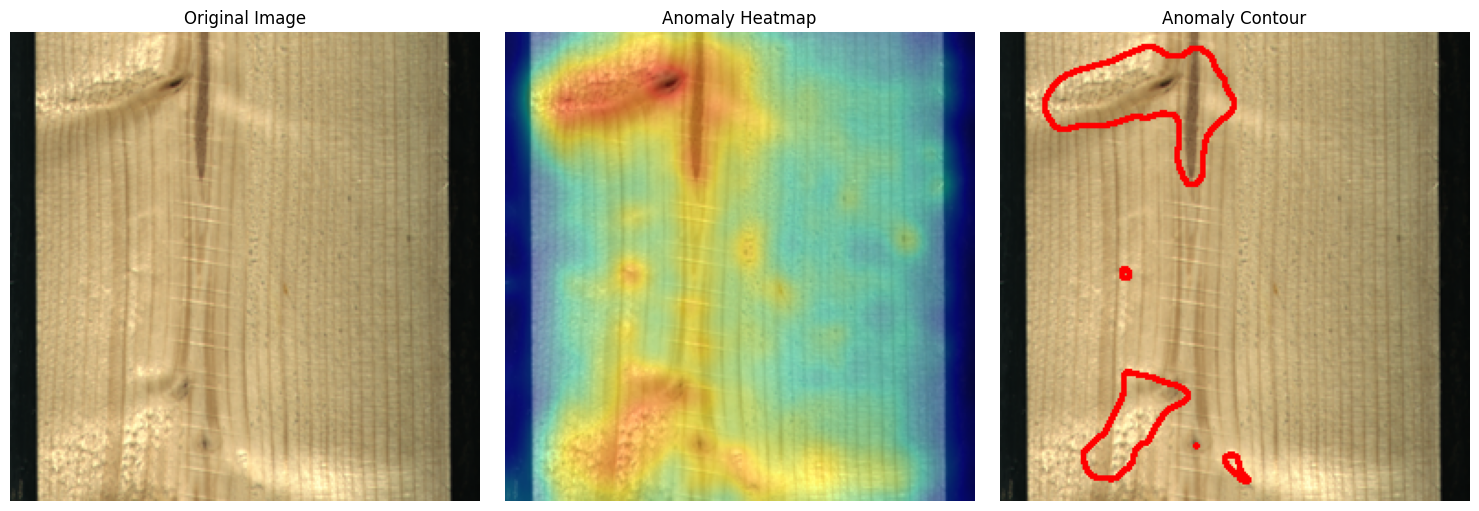

In [20]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import transforms

from model.resnet import wide_resnet50_2
from model.de_resnet import de_wide_resnet50_2
from utils.utils_train import MultiProjectionLayer
from utils.utils_test import cal_anomaly_map

from scipy.ndimage import gaussian_filter

# ===========================
# Custom Normalize & ToTensor
# ===========================

class ToTensor(object):
    def __call__(self, image):
        image = torch.from_numpy(image.transpose(2, 0,1)).float()
        return image

class Normalize(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = np.array(mean)
        self.std = np.array(std)
    def __call__(self, image):
        return (image - self.mean) / self.std

# ====================
# 1. Setup
# ====================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model bileşenleri
encoder, bn = wide_resnet50_2(pretrained=True)
decoder = de_wide_resnet50_2(pretrained=False)
proj_layer = MultiProjectionLayer(base=64)

# Ağırlık yükle
checkpoint = torch.load(
    '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/RRD_Training/wood/wres50_wood.pth',
    map_location=device
)
proj_layer.load_state_dict(checkpoint['proj'])
decoder.load_state_dict(checkpoint['decoder'])
bn.load_state_dict(checkpoint['bn'])

encoder = encoder.to(device).eval()
bn = bn.to(device).eval()
decoder = decoder.to(device).eval()
proj_layer = proj_layer.to(device).eval()

# ====================
# 2. Görsel Yükleme ve Dönüşüm
# ====================
img_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/wood/test/defect/100000012.jpg'
img = Image.open(img_path).convert('RGB')
img_np = np.array(img.resize((256, 256))) / 255.0  # Normalize [0,1]

# Aynı transformlar (Normalize + ToTensor)
transform = transforms.Compose([Normalize(), ToTensor()])
img_tensor = transform(img_np).unsqueeze(0).to(device)

# ====================
# 3. Model Geçişi
# ====================
with torch.no_grad():
    features = encoder(img_tensor)  # [f1, f2, f3]
    proj_features = proj_layer(features)
    decoded_features = decoder(bn(proj_features))  # [d1, d2, d3]

    # Her feature'ı aynı boyuta getir
    decoded_features = [
        F.interpolate(df, size=f.shape[-2:], mode='bilinear', align_corners=True)
        if df.shape[-2:] != f.shape[-2:] else df
        for df, f in zip(decoded_features, features)
    ]

    anomaly_map, _ = cal_anomaly_map(features, decoded_features, out_size=256, amap_mode='a')
    anomaly_map = gaussian_filter(anomaly_map, sigma=4)

# ====================
# 4. Heatmap ve Kontur
# ====================
heatmap = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-6)
heatmap_uint8 = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

input_image_bgr = cv2.cvtColor(np.uint8(img_np * 255), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(input_image_bgr, 0.6, heatmap_color, 0.4, 0)

# Kontur çıkar
threshold = 0.7
binary_mask = (heatmap > threshold).astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoured_image = input_image_bgr.copy()
cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 2)

# ====================
# 5. Gösterim
# ====================
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Anomaly Heatmap")
plt.imshow(overlay[..., ::-1])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Anomaly Contour")
plt.imshow(contoured_image[..., ::-1])
plt.axis("off")

plt.tight_layout()
plt.show()


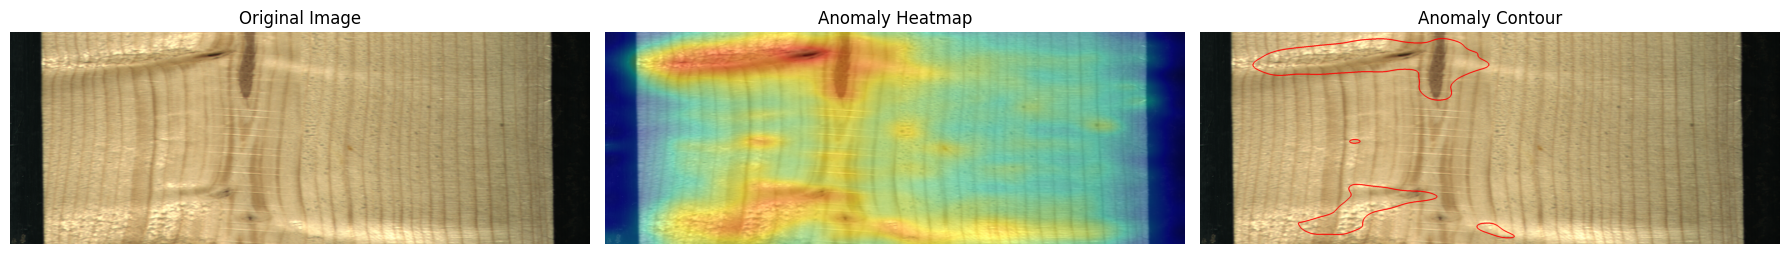

F1 Score: 0.2708
IoU Score (manual): 0.1566


In [22]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from model.resnet import wide_resnet50_2
from model.de_resnet import de_wide_resnet50_2
from utils.utils_train import MultiProjectionLayer
from utils.utils_test import cal_anomaly_map
from scipy.ndimage import gaussian_filter

# Custom transforms
class ToTensor(object):
    def __call__(self, image):
        return torch.from_numpy(image.transpose(2, 0, 1)).float()

class Normalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = np.array(mean)
        self.std = np.array(std)
    def __call__(self, image):
        return (image - self.mean) / self.std

# === 1. Setup ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder, bn = wide_resnet50_2(pretrained=True)
decoder = de_wide_resnet50_2(pretrained=False)
proj_layer = MultiProjectionLayer(base=64)

checkpoint = torch.load(
    '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/RRD_Training/wood/wres50_wood.pth',
    map_location=device
)
proj_layer.load_state_dict(checkpoint['proj'])
decoder.load_state_dict(checkpoint['decoder'])
bn.load_state_dict(checkpoint['bn'])

encoder = encoder.to(device).eval()
bn = bn.to(device).eval()
decoder = decoder.to(device).eval()
proj_layer = proj_layer.to(device).eval()

# === 2. Load original image (any size) ===
img_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/wood/test/defect/100000012.jpg'
img_orig = Image.open(img_path).convert('RGB')
img_orig_np = np.array(img_orig) / 255.0  # [0,1] scale
orig_h, orig_w = img_orig_np.shape[:2]

# Resize for model input
img_resized_np = cv2.resize(img_orig_np, (256, 256))
transform = transforms.Compose([Normalize(), ToTensor()])
img_tensor = transform(img_resized_np).unsqueeze(0).to(device)

# === 3. Forward pass ===
with torch.no_grad():
    features = encoder(img_tensor)
    proj_features = proj_layer(features)
    decoded_features = decoder(bn(proj_features))

    decoded_features = [
        F.interpolate(df, size=f.shape[-2:], mode='bilinear', align_corners=True)
        if df.shape[-2:] != f.shape[-2:] else df
        for df, f in zip(decoded_features, features)
    ]

    anomaly_map, _ = cal_anomaly_map(features, decoded_features, out_size=256, amap_mode='a')
    anomaly_map = gaussian_filter(anomaly_map, sigma=4)

# === 4. Resize back to original size ===
heatmap = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-6)
heatmap_resized = cv2.resize(heatmap, (orig_w, orig_h))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

input_image_bgr = cv2.cvtColor(np.uint8(img_orig_np * 255), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(input_image_bgr, 0.6, heatmap_color, 0.4, 0)

# === 5. Contour detection ===
threshold = 0.70
binary_mask = (heatmap_resized > threshold).astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoured_image = input_image_bgr.copy()
cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 3)  # Red and thicker


# === 6. Plot ===
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_orig_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Anomaly Heatmap")
plt.imshow(overlay[..., ::-1])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Anomaly Contour")
plt.imshow(contoured_image[..., ::-1])
plt.axis("off")

plt.tight_layout()
plt.show()

from sklearn.metrics import f1_score

# === 7. F1 Score Hesaplama ===
# Ground truth maskeyi yükle (aynı boyuta getir)
mask_path = img_path.replace("test", "ground_truth").replace(".jpg", "_mask.jpg")
if os.path.exists(mask_path):
    gt_mask = Image.open(mask_path).convert("L")
    gt_mask = np.array(gt_mask.resize((orig_w, orig_h)))
    gt_mask = (gt_mask > 0).astype(np.uint8)  # Binary mask: 0 or 1

    pred_mask = (heatmap_resized > threshold).astype(np.uint8)

    # Flatten
    f1 = f1_score(gt_mask.flatten(), pred_mask.flatten())
    print(f"F1 Score: {f1:.4f}")
else:
    print("⚠️ Ground truth mask bulunamadı:", mask_path)

from sklearn.metrics import jaccard_score

# === 8. IoU (Jaccard Index) Hesaplama ===
if os.path.exists(mask_path):
    # iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
    # print(f"IoU Score: {iou:.4f}")
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()

    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
    else:
        iou = intersection / union

print(f"IoU Score (manual): {iou:.4f}")


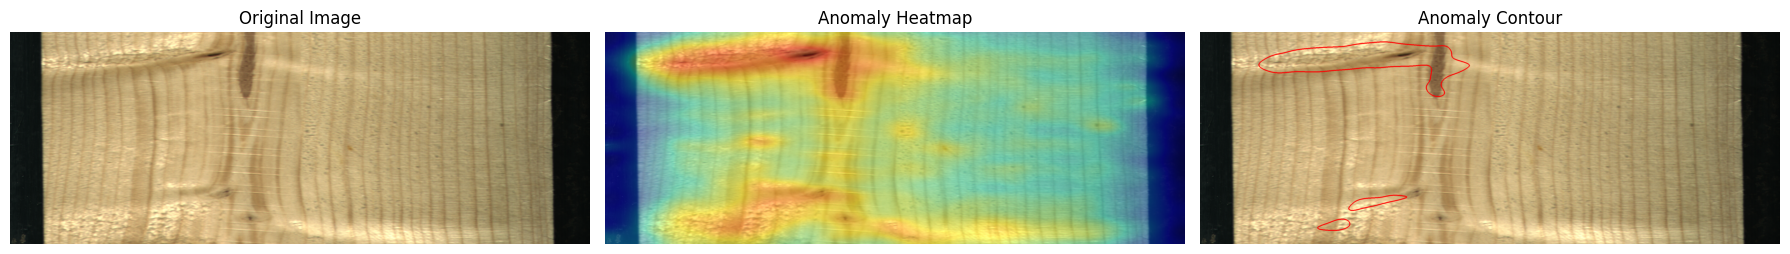

IoU Score (manual): 0.2070
F1 Score: 0.3430
IoU Score: 0.2070


In [23]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from model.resnet import wide_resnet50_2
from model.de_resnet import de_wide_resnet50_2
from utils.utils_train import MultiProjectionLayer
from utils.utils_test import cal_anomaly_map
from scipy.ndimage import gaussian_filter
from sklearn.metrics import f1_score, jaccard_score

# Custom transforms
class ToTensor(object):
    def __call__(self, image):
        return torch.from_numpy(image.transpose(2, 0, 1)).float()

class Normalize(object):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = np.array(mean)
        self.std = np.array(std)
    def __call__(self, image):
        return (image - self.mean) / self.std

# === 1. Setup ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder, bn = wide_resnet50_2(pretrained=True)
decoder = de_wide_resnet50_2(pretrained=False)
proj_layer = MultiProjectionLayer(base=64)

checkpoint = torch.load(
    '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/RRD_Training/wood/wres50_wood.pth',
    map_location=device
)
proj_layer.load_state_dict(checkpoint['proj'])
decoder.load_state_dict(checkpoint['decoder'])
bn.load_state_dict(checkpoint['bn'])

encoder = encoder.to(device).eval()
bn = bn.to(device).eval()
decoder = decoder.to(device).eval()
proj_layer = proj_layer.to(device).eval()

# === 2. Load original image ===
img_path = '/content/drive/MyDrive/Revisiting_Reverse_Dissilation_Training/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/wood/test/defect/100000012.jpg'
# img_path = '/content/drive/MyDrive/RRD_29_04_2025/Revisiting-Reverse-Distillation/mvtec_anomaly_detection/wood/test/good/100.jpg'
img_orig = Image.open(img_path).convert('RGB')
img_orig_np = np.array(img_orig) / 255.0
orig_h, orig_w = img_orig_np.shape[:2]

# Resize for model input
img_resized_np = cv2.resize(img_orig_np, (256, 256))
transform = transforms.Compose([Normalize(), ToTensor()])
img_tensor = transform(img_resized_np).unsqueeze(0).to(device)

# === 3. Forward pass ===
with torch.no_grad():
    features = encoder(img_tensor)
    proj_features = proj_layer(features)
    decoded_features = decoder(bn(proj_features))

    decoded_features = [
        F.interpolate(df, size=f.shape[-2:], mode='bilinear', align_corners=True)
        if df.shape[-2:] != f.shape[-2:] else df
        for df, f in zip(decoded_features, features)
    ]

    anomaly_map, _ = cal_anomaly_map(features, decoded_features, out_size=256, amap_mode='a')
    anomaly_map = gaussian_filter(anomaly_map, sigma=4)

# === 4. Resize heatmap to original ===
heatmap = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-6)
heatmap_resized = cv2.resize(heatmap, (orig_w, orig_h))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

input_image_bgr = cv2.cvtColor(np.uint8(img_orig_np * 255), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(input_image_bgr, 0.6, heatmap_color, 0.4, 0)

# === 5. Contour detection ===
threshold = 0.75
binary_mask = (heatmap_resized > threshold).astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoured_image = input_image_bgr.copy()
cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 3)

# === 6. Plot results ===
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_orig_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Anomaly Heatmap")
plt.imshow(overlay[..., ::-1])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Anomaly Contour")
plt.imshow(contoured_image[..., ::-1])
plt.axis("off")

plt.tight_layout()
plt.show()




# === 7. Metric Evaluation ===
mask_path = img_path.replace("test", "ground_truth").replace(".jpg", "_mask.jpg")
if os.path.exists(mask_path):
    gt_mask = Image.open(mask_path).convert("L")
    gt_mask = gt_mask.resize((orig_w, orig_h), Image.NEAREST)
    gt_mask = np.array(gt_mask)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    pred_mask = (heatmap_resized > threshold).astype(np.uint8)

    if np.sum(gt_mask) == 0 and np.sum(pred_mask) == 0:
        pass
    else:
        f1 = f1_score(gt_mask.ravel(), pred_mask.ravel())
        # === 8. IoU Manual (Area-based) ===
        intersection = np.logical_and(gt_mask, pred_mask).sum()
        union = np.logical_or(gt_mask, pred_mask).sum()

        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union

        print(f"IoU Score (manual): {iou:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"IoU Score: {iou:.4f}")
else:
    pass


